In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import date

In [3]:
from data_preprocessing import *

settings = {
    'directory': '/data/rainbolt/sh4b/mixed_selection/background/',
    'n_seeds': 25, # Used in bkg only
    'trigger_tag': '', # Used in bkg only
    'model_tag': '', # Used in bkg only
    'btag': 77,
    'xbbtag': 70,
    'sig_region': '2dfit', # Options are '2dfit', None
    'bins': None,
    'info': 'WP_Studies_30bins_log',
}

truth_X, truth_S, sig_hists, bkg_hists, bkg_hists_up, bkg_hists_dw = prepare_hist_all(settings)

Getting signals from /data/rainbolt/sh4b/mixed_selection/signal/
for 2018 , mc20e
Getting signals from /data/rainbolt/sh4b/mixed_selection/signal/
for 2017 , mc20d
Getting signals from /data/rainbolt/sh4b/mixed_selection/signal/
for 2016 , mc20a
Getting background
Getting backgrounds for year = 2016
Getting backgrounds for year = 2017
Getting backgrounds for year = 2018


In [4]:
save_name = f'{settings["sig_region"]}_btag{settings["btag"]}_xbbtag{settings["xbbtag"]}_{settings["info"]}_{date.today().strftime("%Y-%m-%d")}'
print('Saving with', save_name)

Saving with 2dfit_btag77_xbbtag70_WP_Studies_30bins_log_2025-03-07


In [5]:
save_dir = f'plots_fit_{save_name}'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [6]:
bkg_mcstat_unc = []
bkg_mcstat_rel_unc = []

sig_mcstat_unc = []
sig_mcstat_rel_unc = []

def get_tot_uncertainty(hist):
    '''
    Args:
    - hist: the histogram with format (bin_content, bins, uncertainties)

    Returns:
    - unc: the absolute uncertainty
    - rel: the relative uncertainty
    '''
    unc = np.sqrt(np.sum(hist[2]**2))
    tot = np.sum(hist[0])
    if tot == 0:
        rel = np.inf
    else:
        rel = unc / tot * 100

    return unc, rel

for S in truth_S:

    bkg_mcstat_unc_s = []
    bkg_mcstat_rel_unc_s = []

    sig_mcstat_unc_s = []
    sig_mcstat_rel_unc_s = []

    for X in truth_X:

        key = f'{X}_{S}'
        bkg_hist = bkg_hists.get(key, None)
        sig_hist = sig_hists.get(key, None)

        if bkg_hist is None or sig_hist is None:
            bkg_unc = bkg_rel = np.inf
            sig_unc = sig_rel = np.inf
        else:
            bkg_unc, bkg_rel = get_tot_uncertainty(bkg_hist)
            sig_unc, sig_rel = get_tot_uncertainty(sig_hist)

        bkg_mcstat_unc_s.append(bkg_unc)
        bkg_mcstat_rel_unc_s.append(bkg_rel)

        sig_mcstat_unc_s.append(sig_unc)
        sig_mcstat_rel_unc_s.append(sig_rel)

    bkg_mcstat_unc.append(bkg_mcstat_unc_s)
    bkg_mcstat_rel_unc.append(bkg_mcstat_rel_unc_s)

    sig_mcstat_unc.append(sig_mcstat_unc_s)
    sig_mcstat_rel_unc.append(sig_mcstat_rel_unc_s)

np.savez(f'plots_fit_{save_name}/saved_bkg_mcstat_unc', bkg_mcstat_unc)
np.savez(f'plots_fit_{save_name}/saved_bkg_mcstat_rel_unc', bkg_mcstat_rel_unc)

np.savez(f'plots_fit_{save_name}/saved_sig_mcstat_unc', sig_mcstat_unc)
np.savez(f'plots_fit_{save_name}/saved_sig_mcstat_rel_unc', sig_mcstat_rel_unc)


Saving... plots_fit/_StatUnc_2dfit_btag77_xbbtag70_WP_Studies_30bins_log_2025-03-07BkgStatUnc.pdf


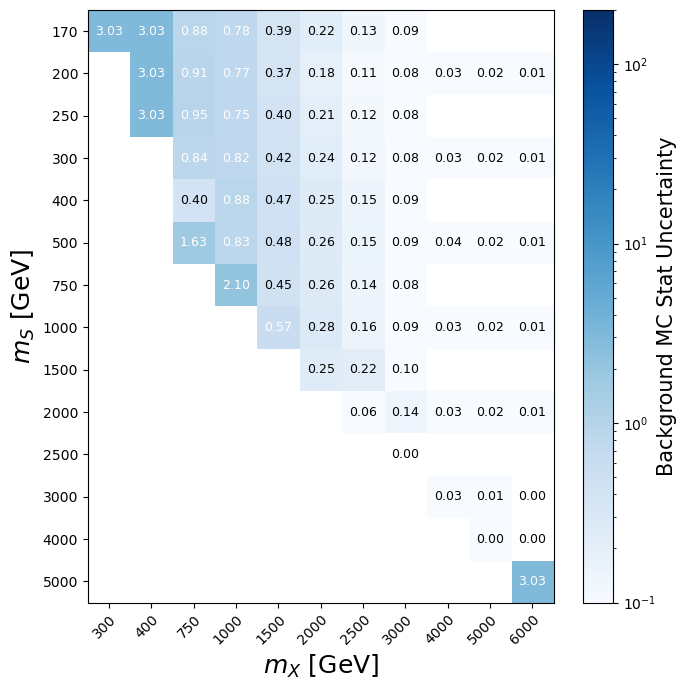

Saving... plots_fit/_StatUnc_2dfit_btag77_xbbtag70_WP_Studies_30bins_log_2025-03-07BkgRelative_StatUnc.pdf


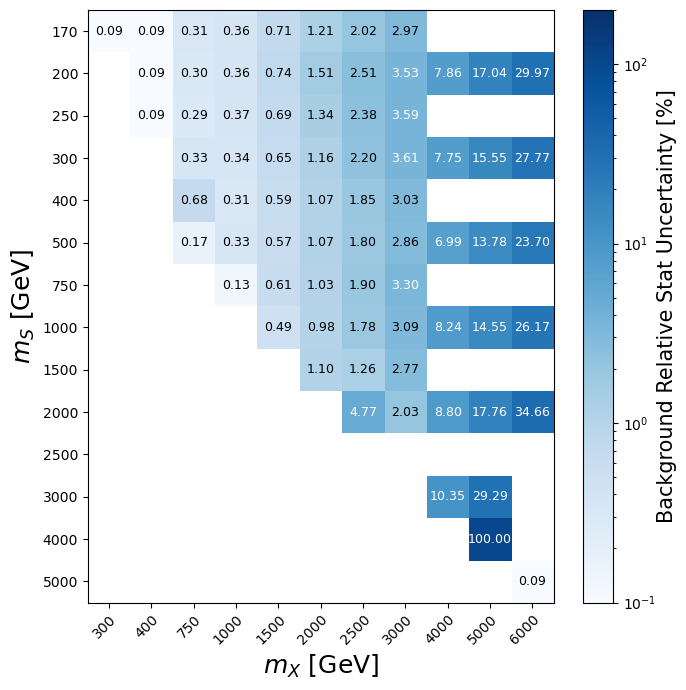

Saving... plots_fit/_StatUnc_2dfit_btag77_xbbtag70_WP_Studies_30bins_log_2025-03-07SigStatUnc.pdf


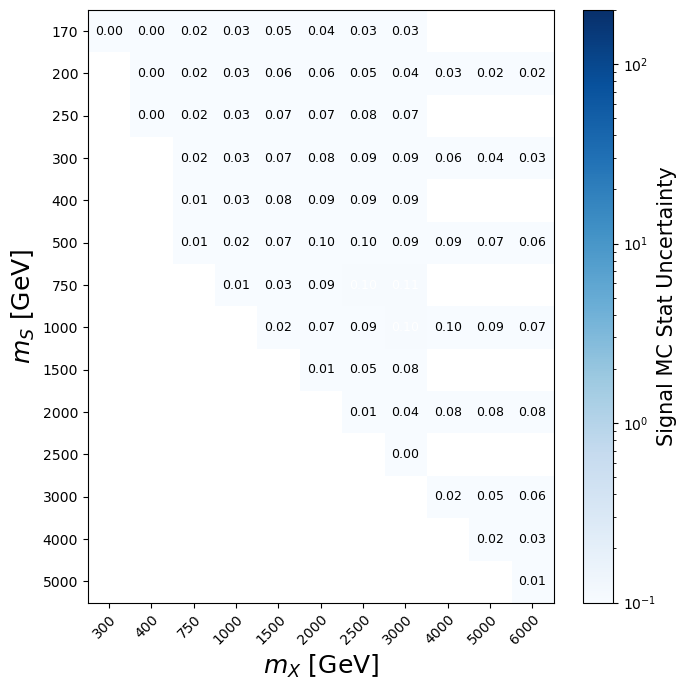

Saving... plots_fit/_StatUnc_2dfit_btag77_xbbtag70_WP_Studies_30bins_log_2025-03-07SigRelative_StatUnc.pdf


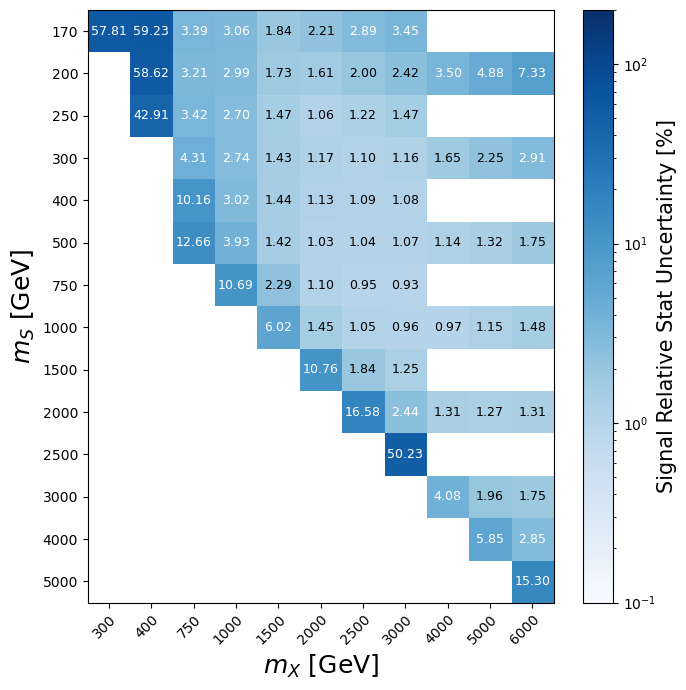

In [7]:
from plotting_tools import annotate_heatmap
from matplotlib.colors import LogNorm

labels_x = []
labels_s = []
for x in sorted(set(truth_X)):
    labels_x.append(str(x))
for s in sorted(set(truth_S)):
    labels_s.append(str(s))
        
def plot_limits(bkg_mcstat_unc,
                name='',
                title='',
                cbar_label='Background MC Stat Uncertainty',
                cmap='Blues',
                color_threshold=0.5,
                comparison=False):
    
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 7))
    
    # if not comparison:
    im = ax.imshow(bkg_mcstat_unc, cmap=cmap, norm=LogNorm(vmin=0.1, vmax=200))
    # else:
    # im = ax.imshow(bkg_mcstat_unc, cmap=cmap, vmin=0, vmax=200)
    
    texts = annotate_heatmap(im, data=None, valfmt="{x:.2f}",# threshold=color_threshold,
                             fontsize=9, ha="center", va="center")
    
    cbar = ax.figure.colorbar(im)
    cbar.ax.set_ylabel("", rotation=-90, va="bottom")
    cbar.set_label(cbar_label, rotation=90, size=15, labelpad=15)
    
    #Show all ticks and label them with the respective list entries
    
    ax.set_xticks(np.arange(len(labels_x)), labels=labels_x)
    ax.set_yticks(np.arange(len(labels_s)), labels=labels_s)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    ax.set_xlabel('$m_{X}$ [GeV]', fontsize=18)
    ax.set_ylabel('$m_{S}$ [GeV]', fontsize=18)
    ax.set_title(title, fontsize=14, loc='right')
    
    fig.tight_layout()
    print("Saving... plots_fit" +"/"+  "_StatUnc_" + name + '.pdf')
    plt.savefig("plots_fit" +"/"+  "_StatUnc_" + name + '.pdf')
    plt.show()

plot_limits(bkg_mcstat_unc, name= save_name + 'BkgStatUnc')
plot_limits(bkg_mcstat_rel_unc, name= save_name + 'BkgRelative_StatUnc', cbar_label='Background Relative Stat Uncertainty [%]')

plot_limits(sig_mcstat_unc, name= save_name + 'SigStatUnc', cbar_label='Signal MC Stat Uncertainty')
plot_limits(sig_mcstat_rel_unc, name= save_name + 'SigRelative_StatUnc', cbar_label='Signal Relative Stat Uncertainty [%]')


In [8]:
pip install pyhf

Note: you may need to restart the kernel to use updated packages.


In [9]:
from fitter import Fitter

def run_fit(truth_S, truth_X, sig_hists, bkg_hists, bkg_hists_up, bkg_hists_dw, name='', quick=False):
    exp_limits = []

    for S in truth_S:

        exp_limits_s = []

        for X in truth_X:

            key = f'{X}_{S}'
            
            # print(key)

            sig = sig_hists.get(key, None)
            bkg = bkg_hists.get(key, None)
            bkg_hists_up_ = bkg_hists_up.get(key, None)
            bkg_hists_dw_ = bkg_hists_dw.get(key, None)

            if sig is None or bkg is None:
                # print('-> Signal is None')
                exp_limits_s.append(np.inf)
                continue
                
            # print(S, X)
            if (S not in [400, 500] or X not in [2000]) and quick:
            # if (S not in [500] or X not in [1500]) and quick:
                # print('->')
                exp_limits_s.append(np.inf)
                continue

            print(f'Fitting X = {X}, S = {S}')

            bins = sig[1]
            
            sig_     = ak.to_numpy(sig[0])
            bkg_     = ak.to_numpy(bkg[0])
            bkg_mcstat_    = ak.to_numpy(bkg[2])
            bkg_hists_up_ = ak.to_numpy(bkg_hists_up_[0])
            bkg_hists_dw_ = ak.to_numpy(bkg_hists_dw_[0])

            fitter = Fitter(sig_, bkg_, bins, X, S, debug=False, save_dir=f'plots_fit_{name}/')

            fitter.set_bkg_vars(bkg_hists_up_, bkg_hists_dw_)
            fitter.set_bkg_mcstat_unc(bkg_mcstat_)
        
            fitter.prepare_fit(plot_summary=True)

            obs_limit, exp_limit = fitter.fit(poi_values=np.linspace(0.01, 350, 500))
            print(f'    exp_limit = {exp_limit}')

            exp_limits_s.append(float(exp_limit))

        exp_limits.append(exp_limits_s)
        
    exp_limits = np.array(exp_limits)
    
    np.savez(f'plots_fit_{name}/saved_limits', exp_limits)

    return exp_limits

In [10]:
labels_x = []
labels_s = []
for x in sorted(set(truth_X)):
    labels_x.append(str(x))
for s in sorted(set(truth_S)):
    labels_s.append(str(s))

In [15]:
exp_limits = run_fit(truth_S, truth_X, sig_hists, bkg_hists, bkg_hists_up, bkg_hists_dw, name=save_name, quick=False)


Fitting X = 300, S = 170
    exp_limit = 350.0
Fitting X = 400, S = 170
    exp_limit = 350.0
Fitting X = 750, S = 170
    exp_limit = 53.348421017382904
Fitting X = 1000, S = 170
    exp_limit = 26.14607141857372
Fitting X = 1500, S = 170
    exp_limit = 5.494201308227654
Fitting X = 2000, S = 170
    exp_limit = 4.336363233681466
Fitting X = 2500, S = 170
    exp_limit = 4.754802064614428
Fitting X = 3000, S = 170
    exp_limit = 5.262467796183823
Fitting X = 400, S = 200
    exp_limit = 350.0
Fitting X = 750, S = 200
    exp_limit = 48.225285690858584
Fitting X = 1000, S = 200
    exp_limit = 25.085507211391107
Fitting X = 1500, S = 200
    exp_limit = 4.173539243883859
Fitting X = 2000, S = 200
    exp_limit = 2.0010147228160076
Fitting X = 2500, S = 200
    exp_limit = 2.049227607230891
Fitting X = 3000, S = 200
    exp_limit = 2.444927423528694
Fitting X = 4000, S = 200
    exp_limit = 3.4264125325205788
Fitting X = 5000, S = 200
    exp_limit = 5.278595651616621
Fitting X = 6000

/usr/local/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


    exp_limit = 51.870757480455076
Fitting X = 1500, S = 500
    exp_limit = 3.471604043992627
Fitting X = 2000, S = 500
    exp_limit = 1.2270464113882242
Fitting X = 2500, S = 500
    exp_limit = 0.7080572641865066
Fitting X = 3000, S = 500
    exp_limit = 0.684584530155661
Fitting X = 4000, S = 500
    exp_limit = 0.6758150724673231
Fitting X = 5000, S = 500
    exp_limit = 0.6761626602225514
Fitting X = 6000, S = 500
    exp_limit = 0.7014704114932043
Fitting X = 1000, S = 750
    exp_limit = 350.0
Fitting X = 1500, S = 750
    exp_limit = 10.721557621438633
Fitting X = 2000, S = 750
    exp_limit = 1.305075685674958
Fitting X = 2500, S = 750
    exp_limit = 0.6868704804981252
Fitting X = 3000, S = 750
    exp_limit = 0.6751372425875671
Fitting X = 1500, S = 1000
    exp_limit = 62.813382835323424
Fitting X = 2000, S = 1000
    exp_limit = 2.120773956215565
Fitting X = 2500, S = 1000
    exp_limit = 0.7078051776580914
Fitting X = 3000, S = 1000
    exp_limit = 0.6763707517495803
Fi

In [16]:
from plotting_tools import annotate_heatmap
from matplotlib.colors import LogNorm

labels_x = []
labels_s = []
for x in sorted(set(truth_X)):
    labels_x.append(str(x))
for s in sorted(set(truth_S)):
    labels_s.append(str(s))
        
def plot_limits(exp_limits,
                name='',
                title='',
                cbar_label='95% CL Upper Limit on Cross Section [fb]',
                cmap='Blues',
                color_threshold=0.5,
                comparison=False):
    
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 7))

    if not comparison:
        im = ax.imshow(exp_limits, cmap=cmap, norm=LogNorm(vmin=0.1, vmax=350))
    else:
        im = ax.imshow(exp_limits, cmap=cmap, vmin=-100, vmax=100)

    texts = annotate_heatmap(im, data=None, valfmt="{x:.1f}", threshold=color_threshold,
                             fontsize=9, ha="center", va="center")

    cbar = ax.figure.colorbar(im)
    cbar.ax.set_ylabel("", rotation=-90, va="bottom")
    cbar.set_label(cbar_label, rotation=90, size=15, labelpad=15)

    #Show all ticks and label them with the respective list entries

    ax.set_xticks(np.arange(len(labels_x)), labels=labels_x)
    ax.set_yticks(np.arange(len(labels_s)), labels=labels_s)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    ax.set_xlabel('$m_{X}$ [GeV]', fontsize=18)
    ax.set_ylabel('$m_{S}$ [GeV]', fontsize=18)
    ax.set_title(title, fontsize=14, loc='right')

    fig.tight_layout()
    print("Saving... plots_fit" +"/" + name + '.pdf')
    plt.savefig("plots_fit" +"/" + name + '.pdf')
    plt.show()

In [ ]:
# print(exp_limits.shape)
# print(len(labels_x), len(labels_s))

Saving... plots_fit/Limits_NF_2dfit_btag77_xbbtag70_WP_Studies_30bins_log_2025-03-07.pdf


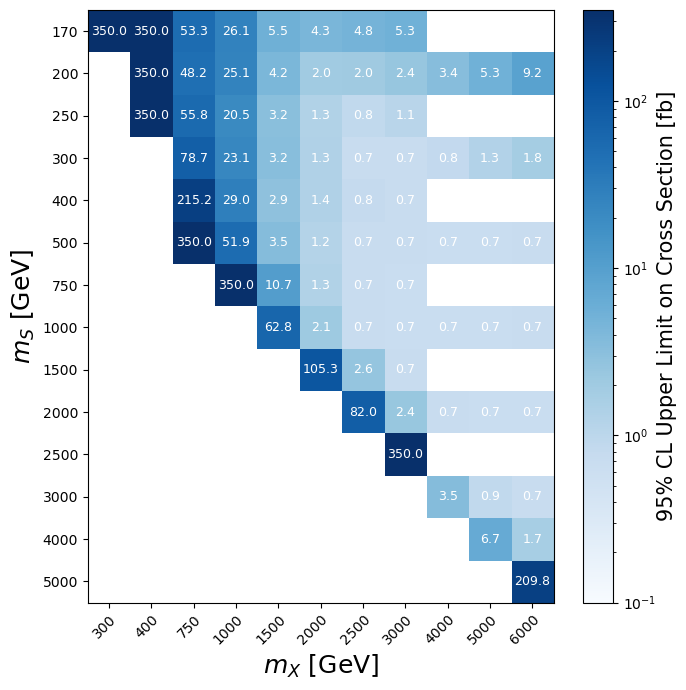

In [17]:
plot_limits(exp_limits, name= "Limits_NF_" + save_name)

In [18]:
# limits_77_70     = np.load(f'plots_fit_LR_2b1j_2dfit_seeds25_WP_77_70_2025-02-19/saved_limits.npz')
# exp_limits_77_70 = limits_77_70['arr_0']

# limits_70_70     = np.load(f'plots_fit_LR_2b1j_2dfit_btag70_xbbtag70_WP_Studies_2025-02-24/saved_limits.npz')
# exp_limits_70_70 = limits_70_70['arr_0']

# limits_77_60     = np.load(f'plots_fit_LR_2b1j_2dfit_btag77_xbbtag60_WP_Studies_2025-02-24/saved_limits.npz')
# exp_limits_77_60 = limits_77_60['arr_0']

# limits_85_70     = np.load(f'plots_fit_LR_2b1j_2dfit_btag85_xbbtag70_WP_Studies_2025-02-24/saved_limits.npz')
# exp_limits_85_70 = limits_85_70['arr_0']

# limits_70_60     = np.load(f'plots_fit_LR_2b1j_2dfit_btag70_xbbtag60_WP_Studies_2025-02-24/saved_limits.npz')
# exp_limits_70_60 = limits_70_60['arr_0']

limits_77_70_new     = np.load(f'plots_fit_2dfit_btag77_xbbtag70_WP_Studies_2025-03-06/saved_limits.npz')
exp_limits_77_70_new = limits_77_70_new['arr_0']

limits_77_70_with_bkg_stat     = np.load(f'plots_fit_2dfit_btag77_xbbtag70_WP_Studies_30bins_log_with_bkg_MCstat_2025-03-07/saved_limits.npz')
exp_limits_77_70_with_bkg_stat = limits_77_70_with_bkg_stat['arr_0']

limits_70_70     = np.load(f'plots_fit_2dfit_btag70_xbbtag70_WP_Studies_2025-03-06/saved_limits.npz')
exp_limits_70_70 = limits_70_70['arr_0']

limits_77_80     = np.load(f'plots_fit_2dfit_btag77_xbbtag80_WP_Studies_2025-03-06/saved_limits.npz')
exp_limits_77_80 = limits_77_80['arr_0']

limits_77_65     = np.load(f'plots_fit_2dfit_btag77_xbbtag65_WP_Studies_2025-02-28/saved_limits.npz')
exp_limits_77_65 = limits_77_65['arr_0']

limits_77_60     = np.load(f'plots_fit_2dfit_btag77_xbbtag60_WP_Studies_2025-03-06/saved_limits.npz')
exp_limits_77_60 = limits_77_60['arr_0']

limits_77_55     = np.load(f'plots_fit_2dfit_btag77_xbbtag55_WP_Studies_2025-03-03/saved_limits.npz')
exp_limits_77_55 = limits_77_55['arr_0']

limits_77_50     = np.load(f'plots_fit_2dfit_btag77_xbbtag50_WP_Studies_2025-03-03/saved_limits.npz')
exp_limits_77_50 = limits_77_50['arr_0']

limits_85_70     = np.load(f'plots_fit_2dfit_btag85_xbbtag70_WP_Studies_2025-03-06/saved_limits.npz')
exp_limits_85_70 = limits_85_70['arr_0']

limits_85_65     = np.load(f'plots_fit_2dfit_btag85_xbbtag65_WP_Studies_2025-03-03/saved_limits.npz')
exp_limits_85_65 = limits_85_65['arr_0']

limits_85_55     = np.load(f'plots_fit_2dfit_btag85_xbbtag55_WP_Studies_2025-03-05/saved_limits.npz')
exp_limits_85_55 = limits_85_55['arr_0']

limits_85_50     = np.load(f'plots_fit_2dfit_btag85_xbbtag50_WP_Studies_2025-03-05/saved_limits.npz')
exp_limits_85_50 = limits_85_50['arr_0']


/tmp/ipykernel_1269/2051827532.py:1: RuntimeWarning: invalid value encountered in subtract
  perc_diff = (exp_limits_77_70_with_bkg_stat - exp_limits_77_70_new) / exp_limits_77_70_new * 100


Saving... plots_fit/Limits_NF_77_70_with_bkg_MCstat_vs_77_70_7Mar.pdf


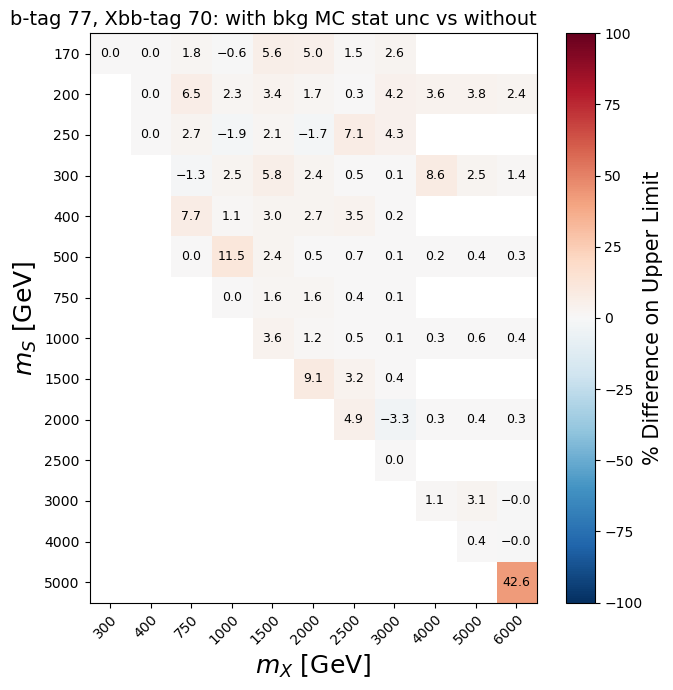

In [20]:
perc_diff = (exp_limits_77_70_with_bkg_stat - exp_limits_77_70_new) / exp_limits_77_70_new * 100
plot_limits(perc_diff, name='Limits_NF_77_70_with_bkg_MCstat_vs_77_70_7Mar',
            title='b-tag 77, Xbb-tag 70: with bkg MC stat unc vs without',
            cbar_label='% Difference on Upper Limit',
            cmap='RdBu_r',
            color_threshold=100,
            comparison=True)

In [ ]:
stat_unc_77_70_new     = np.load(f'plots_fit_2dfit_btag77_xbbtag70_WP_Studies_2025-03-06/saved_bkg_mcstat_rel_unc.npz')
exp_stat_unc_77_70_new = stat_unc_77_70_new['arr_0']

stat_unc_70_70     = np.load(f'plots_fit_2dfit_btag70_xbbtag70_WP_Studies_2025-03-06/saved_bkg_mcstat_rel_unc.npz')
exp_stat_unc_70_70 = stat_unc_70_70['arr_0']

stat_unc_77_80     = np.load(f'plots_fit_2dfit_btag77_xbbtag80_WP_Studies_2025-03-06/saved_bkg_mcstat_rel_unc.npz')
exp_stat_unc_77_80 = stat_unc_77_80['arr_0']

stat_unc_77_65     = np.load(f'plots_fit_2dfit_btag77_xbbtag65_WP_Studies_2025-02-28/saved_bkg_mcstat_rel_unc.npz')
exp_stat_unc_77_65 = stat_unc_77_65['arr_0']

stat_unc_77_60     = np.load(f'plots_fit_2dfit_btag77_xbbtag60_WP_Studies_2025-03-06/saved_bkg_mcstat_rel_unc.npz')
exp_stat_unc_77_60 = stat_unc_77_60['arr_0']

stat_unc_77_55     = np.load(f'plots_fit_2dfit_btag77_xbbtag55_WP_Studies_2025-03-03/saved_bkg_mcstat_rel_unc.npz')
exp_stat_unc_77_55 = stat_unc_77_55['arr_0']

stat_unc_77_50     = np.load(f'plots_fit_2dfit_btag77_xbbtag50_WP_Studies_2025-03-03/saved_bkg_mcstat_rel_unc.npz')
exp_stat_unc_77_50 = stat_unc_77_50['arr_0']

stat_unc_85_70     = np.load(f'plots_fit_2dfit_btag85_xbbtag70_WP_Studies_2025-03-06/saved_bkg_mcstat_rel_unc.npz')
exp_stat_unc_85_70 = stat_unc_85_70['arr_0']

stat_unc_85_65     = np.load(f'plots_fit_2dfit_btag85_xbbtag65_WP_Studies_2025-03-03/saved_bkg_mcstat_rel_unc.npz')
exp_stat_unc_85_65 = stat_unc_85_65['arr_0']

stat_unc_85_55     = np.load(f'plots_fit_2dfit_btag85_xbbtag55_WP_Studies_2025-03-05/saved_bkg_mcstat_rel_unc.npz')
exp_stat_unc_85_55 = stat_unc_85_55['arr_0']

stat_unc_85_50     = np.load(f'plots_fit_2dfit_btag85_xbbtag50_WP_Studies_2025-03-05/saved_bkg_mcstat_rel_unc.npz')
exp_stat_unc_85_50 = stat_unc_85_50['arr_0']


In [ ]:
perc_diff = exp_stat_unc_85_50 - exp_stat_unc_77_70_new
plot_limits(perc_diff, name='StatUnc_85_50_vs_77_70_6Mar',
            title='b-tag 85, Xbb-tag 50 vs b-tag 77, Xbb-tag 70',
            cbar_label='Difference on Relative Uncertainty [percentage points]',
            cmap='RdBu_r',
            color_threshold=100,
            comparison=True)

In [ ]:
perc_diff = (exp_limits_200bins_linspace - exp_limits_77_70) / exp_limits_77_70 * 100
plot_limits(perc_diff, name='200binsLinspace_vs_30binsLogspace_25Feb',
            title='200 bins Linspace vs 30 bins Logspace',
            cbar_label='% Difference on Upper Limit',
            cmap='RdBu_r',
            color_threshold=100,
            comparison=True)

### Rebin the histograms and run the limits again

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class HistogramRebinning:
    def __init__(self, sig_hist, bkg_hist, z_s=8, z_b=2):
        self.sig_counts, self.sig_edges = sig_hist
        self.bkg_counts, self.bkg_edges = bkg_hist
        self.z_s = z_s
        self.z_b = z_b

        # Ensure histograms have the same bin edges
        assert np.allclose(self.sig_edges, self.bkg_edges), "Histogram edges must match."

    def rebin_histograms(self):
        sig_counts = self.sig_counts.copy()
        bkg_counts = self.bkg_counts.copy()
        bin_edges = list(self.sig_edges)

        N_s = np.sum(sig_counts)
        N_b = np.sum(bkg_counts)

        new_edges = [bin_edges[-1]]  # Start from the rightmost edge
        sig_rebinned = []
        bkg_rebinned = []

        n_s = 0
        n_b = 0

        # Iteratively merge bins
        for i in reversed(range(len(sig_counts))):
            n_s += sig_counts[i]
            n_b += bkg_counts[i]

            # llrs = n_s/(np.sqrt(n_b))
            # llrb = n_b/(np.sqrt(n_s))
            # LLRs = N_s/(np.sqrt(N_b))
            # LLRb = N_b/(np.sqrt(N_s))
            
            # Calculate the Z function
            # Z = self.z_s * (n_s / N_s) + self.z_b * (n_b / N_b)
            # Z_E = np.sqrt((self.z_s*llrs)/LLRs) + np.sqrt((self.z_b*llrb)/LLRb)

            # sigma = n_s/(np.sqrt(n_s+n_b))
            stat_unc_s = 1/(np.sqrt(n_s))
            stat_unc_b = 1/(np.sqrt(n_b))
            
            # print(f"Z = {Z}, n_s = {n_s}, n_b = {n_b}, sigma = {sigma}")

            # if Z > 1:
            if stat_unc_b < 0.2:
                # Create a new bin
                # print(f"Z = {Z}, n_s = {n_s}, n_b = {n_b}, sigma = {sigma}")
                
                new_edges.append(bin_edges[i])
                sig_rebinned.append(n_s)
                bkg_rebinned.append(n_b)
                n_s = 0
                n_b = 0

        # Handle any remaining events
        if n_s > 0 or n_b > 0:
            new_edges.append(bin_edges[0])
            sig_rebinned.append(n_s)
            bkg_rebinned.append(n_b)

        # Reverse lists to correct order
        new_edges.reverse()
        sig_rebinned.reverse()
        bkg_rebinned.reverse()

        return new_edges, sig_rebinned, bkg_rebinned

    def rebin_fixed_bins(self, old_counts, old_edges, new_edges):
        """Rebins histogram counts from old_edges into new_edges."""
        new_counts = np.histogram(old_edges[:-1], bins=new_edges, weights=old_counts)[0]
        return new_counts
    
    def plot_histograms(self, bin_edges, sig_counts, bkg_counts):
        fig, ax = plt.subplots(figsize=(8, 5))
        bin_widths = np.diff(bin_edges)
        # ax.bar(bin_edges[:-1], bkg_counts, width=bin_widths, align='edge', alpha=0.5, label='Background')
        # ax.bar(bin_edges[:-1], sig_counts, width=bin_widths, align='edge', alpha=0.9, label='Signal')
        
        # ax.step(bin_edges, np.append(sig_counts, sig_counts[-1]), where='post', linestyle='-', linewidth=2, label='Signal', color='blue')
        # ax.step(bin_edges, np.append(bkg_counts, bkg_counts[-1]), where='post', linestyle='-', linewidth=2, label='Background', color='red')

        ax.stairs(sig_counts, bin_edges, linestyle='-', linewidth=2, label='Signal')
        ax.stairs(bkg_counts, bin_edges, linestyle='-', linewidth=2, label='Background')

        ax.set_xlabel('Variable')
        ax.set_ylabel('Counts')
        ax.set_yscale('log')  # Set the y-axis to logarithmic scale
        ax.legend()
        ax.set_title('Rebinned Histograms')
        plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Dictionaries to store rebinned histograms
rebinned_sig_hists = {}
rebinned_bkg_hists = {}
rebinned_bkg_hists_up = {}
rebinned_bkg_hists_dw = {}

z_s=4 
z_b=3

save_dir_rebin = f'plots_fit_{save_name}_zs_{z_s}_zb_{z_b}'
if not os.path.exists(save_dir_rebin):
    os.makedirs(save_dir_rebin)
    
for key in sig_hists.keys():
    if key not in bkg_hists:
        print(f"Warning: Missing background histogram for key {key}, skipping...")
        continue
    
    # Get signal and background histograms
    sig_counts, sig_edges = sig_hists[key]
    bkg_counts, bkg_edges = bkg_hists[key]
    
    # Perform rebinning
    rebin_algo = HistogramRebinning((sig_counts, sig_edges), (bkg_counts, bkg_edges), z_s=z_s, z_b=z_b)
    new_edges, new_sig_counts, new_bkg_counts = rebin_algo.rebin_histograms()
    
    # Store rebinned histograms
    rebinned_sig_hists[key] = (new_sig_counts, new_edges)
    rebinned_bkg_hists[key] = (new_bkg_counts, new_edges)

    # Rebin the systematic variations if they exist
    new_bkg_counts_up = new_bkg_counts_dw = None  # Default to None if not found

    if key in bkg_hists_up:
        new_bkg_counts_up = rebin_algo.rebin_fixed_bins(bkg_hists_up[key][0], bkg_hists_up[key][1], new_edges)
        rebinned_bkg_hists_up[key] = (new_bkg_counts_up, new_edges)

    if key in bkg_hists_dw:
        new_bkg_counts_dw = rebin_algo.rebin_fixed_bins(bkg_hists_dw[key][0], bkg_hists_dw[key][1], new_edges)
        rebinned_bkg_hists_dw[key] = (new_bkg_counts_dw, new_edges)

    # Plot the rebinned histograms
    print(f"Plotting rebinned histograms for key: {key}")
    fig, ax = plt.subplots(figsize=(8, 5))

    # Plot signal and background with updated colors
    ax.stairs(new_sig_counts, new_edges, linestyle='-', linewidth=2, label='Signal', color='#ff7f0e')  # Orange
    ax.stairs(new_bkg_counts, new_edges, linestyle='-', linewidth=2, label='Background', color='#1f77b4')  # Dark Blue

    # Plot background variations
    if new_bkg_counts_up is not None:
        ax.stairs(new_bkg_counts_up, new_edges, linestyle='--', linewidth=1.5, label='Bkg Up', color='#aec7e8')  # Light Blue

    if new_bkg_counts_dw is not None:
        ax.stairs(new_bkg_counts_dw, new_edges, linestyle='--', linewidth=1.5, label='Bkg Down', color='#6baed6')  # Sky Blue

    ax.set_xlabel('Variable')
    ax.set_ylabel('Counts')
    ax.set_yscale('log')  # Log scale for better visualization
    ax.legend()
    ax.set_title(f'Rebinned Histograms - {key}')
            
    print(f'Saving... {save_dir_rebin}/Rebinned_histograms_{save_name}_StatUnc20perc_{key}.pdf')
    # print(f'Saving... {save_dir_rebin}/Rebinned_histograms_{save_name}_zs_{z_s}_zb_{z_b}_{key}.pdf')
    # plt.savefig(f'{save_dir_rebin}/Rebinned_histograms_{save_name}_zs_{z_s}_zb_{z_b}_{key}.pdf')
    plt.savefig(f'{save_dir_rebin}/Rebinned_histograms_{save_name}_StatUnc20perc_{key}.pdf')
    # plt.savefig(f"plots_fit_{save_name}/Rebinned_histograms_{save_name}_zs_" + str(z_s)+ '_zb_' + str(z_b)+'_' +key +'.pdf')

    plt.show()


In [ ]:
# exp_limits_rebinned = run_fit(truth_S, truth_X, rebinned_sig_hists, rebinned_bkg_hists, rebinned_bkg_hists_up, rebinned_bkg_hists_dw, name=save_name+'_rebinned_zs5_zb2', quick=False)
exp_limits_rebinned = run_fit(truth_S, truth_X, rebinned_sig_hists, rebinned_bkg_hists, rebinned_bkg_hists_up, rebinned_bkg_hists_dw, name=save_name+'_rebinned_lin200_zs4_zb3', quick=False)


In [ ]:
# plot_limits(exp_limits_rebinned, name=save_name +'_rebinned_zs5_zb2')
plot_limits(exp_limits_rebinned, name=save_name +'_rebinned_lin200_zs4_zb3')


In [ ]:
limits_Default     = np.load(f'plots_fit_LR_2b1j_2dfit_btag77_xbbtag70_Rebinning_Studies_2025-02-23/saved_limits.npz')
exp_limits_Default = limits_Default['arr_0']

limits_rebinned_200bins     = np.load(f'plots_fit_LR_2b1j_2dfit_btag77_xbbtag70_Rebinning_Studies_200bins_2025-02-23/saved_limits.npz')
exp_limits_rebinned_200bins = limits_rebinned_200bins['arr_0']

limits_rebinned_zs0_zb5     = np.load(f'plots_fit_LR_2b1j_2dfit_btag77_xbbtag70_Rebinning_Studies_2025-02-23_rebinned_zs0_zb5/saved_limits.npz')
exp_limits_rebinned_zs0_zb5 = limits_rebinned_zs0_zb5['arr_0']

limits_rebinned_zs1_zb4     = np.load(f'plots_fit_LR_2b1j_2dfit_btag77_xbbtag70_Rebinning_Studies_2025-02-23_rebinned_zs1_zb4/saved_limits.npz')
exp_limits_rebinned_zs1_zb4 = limits_rebinned_zs1_zb4['arr_0']

limits_rebinned_zs2_zb3     = np.load(f'plots_fit_LR_2b1j_2dfit_btag77_xbbtag70_Rebinning_Studies_2025-02-23_rebinned_zs2_zb3/saved_limits.npz')
exp_limits_rebinned_zs2_zb3 = limits_rebinned_zs2_zb3['arr_0']

limits_rebinned_zs3_zb2     = np.load(f'plots_fit_LR_2b1j_2dfit_btag77_xbbtag70_Rebinning_Studies_2025-02-23_rebinned_zs3_zb2/saved_limits.npz')
exp_limits_rebinned_zs3_zb2 = limits_rebinned_zs3_zb2['arr_0']

limits_rebinned_zs4_zb1     = np.load(f'plots_fit_LR_2b1j_2dfit_btag77_xbbtag70_Rebinning_Studies_2025-02-23_rebinned_zs4_zb1/saved_limits.npz')
exp_limits_rebinned_zs4_zb1 = limits_rebinned_zs4_zb1['arr_0']

limits_rebinned_zs5_zb0     = np.load(f'plots_fit_LR_2b1j_2dfit_btag77_xbbtag70_Rebinning_Studies_2025-02-23_rebinned_zs5_zb0/saved_limits.npz')
exp_limits_rebinned_zs5_zb0 = limits_rebinned_zs5_zb0['arr_0']

limits_rebinned_200bins_zs3_zb2     = np.load(f'plots_fit_LR_2b1j_2dfit_btag77_xbbtag70_Rebinning_Studies_200bins_2025-02-23_rebinned_zs3_zb2/saved_limits.npz')
exp_limits_rebinned_200bins_zs3_zb2 = limits_rebinned_200bins_zs3_zb2['arr_0']

limits_rebinned_200bins_zs2_zb4     = np.load(f'plots_fit_LR_2b1j_2dfit_btag77_xbbtag70_Rebinning_Studies_200bins_2025-02-23_rebinned_zs2_zb4/saved_limits.npz')
exp_limits_rebinned_200bins_zs2_zb4 = limits_rebinned_200bins_zs2_zb4['arr_0']

limits_rebinned_200bins_zs5_zb5     = np.load(f'plots_fit_LR_2b1j_2dfit_btag77_xbbtag70_Rebinning_Studies_200bins_2025-02-23_rebinned_zs5_zb5/saved_limits.npz')
exp_limits_rebinned_200bins_zs5_zb5 = limits_rebinned_200bins_zs5_zb5['arr_0']

limits_rebinned_200bins_zs5_zb2     = np.load(f'plots_fit_LR_2b1j_2dfit_btag77_xbbtag70_Rebinning_Studies_200bins_2025-02-23_rebinned_zs5_zb2/saved_limits.npz')
exp_limits_rebinned_200bins_zs5_zb2 = limits_rebinned_200bins_zs5_zb2['arr_0']

limits_rebinned_200bins_StatUnc     = np.load(f'plots_fit_LR_2b1j_2dfit_btag77_xbbtag70_Rebinning_stat_unc_200bins_2025-02-24_rebinned_StatUnc20perc/saved_limits.npz')
exp_limits_rebinned_200bins_StatUnc = limits_rebinned_200bins_StatUnc['arr_0']

limits_lin200    = np.load(f'plots_fit_LR_2b1j_2dfit_btag77_xbbtag70_Rebinning_Linspace_2025-02-25/saved_limits.npz')
exp_limits_lin200 = limits_lin200['arr_0']

limits_rebinned_lin200_zs4_zb3    = np.load(f'plots_fit_LR_2b1j_2dfit_btag77_xbbtag70_Rebinning_Linspace_2025-02-25_rebinned_lin200_zs4_zb3/saved_limits.npz')
exp_limits_rebinned_lin200_zs4_zb3 = limits_rebinned_lin200_zs4_zb3['arr_0']


In [ ]:
perc_diff = (exp_limits_lin200 - exp_limits_rebinned_200bins) / exp_limits_rebinned_200bins * 100
plot_limits(perc_diff, name='2DFit200bins_Lin_vs_Log_Feb25',
            title='Linear 200 bins vs Log 200 bins',
            cbar_label='% Difference on Upper Limit',
            cmap='RdBu_r',
            color_threshold=100,
            comparison=True)